In [ ]:
#importing dependencies
%%capture
!pip install spektral
import numpy as np
import os
import networkx as nx
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.metrics import classification_report

from spektral.layers import GCNConv

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
import tensorflow as tf
from tensorflow.keras.regularizers import l2

from collections import Counter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import networkx as nx

In [ ]:
import pydot
import requests
import numpy as np
import pandas as pd
import ast
from pandas.api.types import CategoricalDtype

def load(filepath):
  if 'features' in filepath:
    return pd.read_csv(filepath, index_col=0, header=[0, 1, 2])
  if 'tracks' in filepath:
    tracks = pd.read_csv('/content/drive/MyDrive/CS685 data mining/Dataset/fma_metadata/tracks.csv', index_col=0, header=[0, 1])

    COLUMNS = [('track', 'tags'), ('album', 'tags'), ('artist', 'tags'),('track', 'genres'), ('track', 'genres_all')]
    for column in COLUMNS:
        tracks[column] = tracks[column].map(ast.literal_eval)

    COLUMNS = [('track', 'date_created'), ('track', 'date_recorded'),
                ('album', 'date_created'), ('album', 'date_released'),
                ('artist', 'date_created'), ('artist', 'active_year_begin'),
                ('artist', 'active_year_end')]
    for column in COLUMNS:
        tracks[column] = pd.to_datetime(tracks[column])

    SUBSETS = ('small', 'medium', 'large')
    cat_type = CategoricalDtype(categories=SUBSETS, ordered=True)
    try:
        tracks['set', 'subset'] = tracks['set', 'subset'].astype(cat_type)
    except ValueError:
        # the categories and ordered arguments were removed in pandas 0.25
        tracks['set', 'subset'] = tracks['set', 'subset'].astype(pd.CategoricalDtype(categories=SUBSETS, ordered=True))

    COLUMNS = [('track', 'genre_top'), ('track', 'license'),
                ('album', 'type'), ('album', 'information'),
                ('artist', 'bio')]
    for column in COLUMNS:
        tracks[column] = tracks[column].astype('category')

    return tracks
  
def subset_data(features,tracks,subset='small'):
  bool_subset = tracks['set', 'subset'] <= subset
  features = features.loc[bool_subset, :]
  tracks = tracks.loc[bool_subset, :]
  # tracks = tracks.loc[bool_subset, ('track', 'genre_top')]
  return features,tracks

In [ ]:
data_dir_path = '/content/drive/MyDrive/CS685 data mining/Dataset/fma_metadata/'
features_data = load(data_dir_path+'features.csv')
tracks_data = load(data_dir_path+'tracks.csv')
print('features_data\n',features_data.head(),features_data.shape)
print('tracks_data\n',tracks_data.head(),tracks_data.shape)
print('features_data first column',features_data.head().iloc[:,0])


features_data
 feature    chroma_cens                      ...       zcr                    
statistics    kurtosis                      ...       min      skew       std
number              01        02        03  ...        01        01        01
track_id                                    ...                              
2             7.180653  5.230309  0.249321  ...  0.000000  2.089872  0.061448
3             1.888963  0.760539  0.345297  ...  0.000000  1.716724  0.069330
5             0.527563 -0.077654 -0.279610  ...  0.000000  2.193303  0.044861
10            3.702245 -0.291193  2.196742  ...  0.000000  3.542325  0.040800
20           -0.193837 -0.198527  0.201546  ...  0.000977  3.189831  0.030993

[5 rows x 518 columns] (106574, 518)
tracks_data
             album                      ... track                 
         comments        date_created  ...  tags            title
track_id                               ...                       
2               0 2008-11-26 01:44

In [ ]:
features_subset,tracks_subset = subset_data(features_data,tracks_data,subset='small')
np.testing.assert_array_equal(features_subset.index, tracks_subset.index)
X  = np.array(features_subset.values)
Y = np.array(tracks_subset.loc[:,('track', 'genre_top')].values)

In [ ]:
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(X)


In [ ]:
from sklearn.decomposition import KernelPCA
kpca=KernelPCA(n_components=187)
X=kpca.fit_transform(X)

In [ ]:
from sklearn.model_selection import train_test_split
from collections import Counter
import random

def split_index(X,Y,train_size=0.5,test_size = 0.25,valid_size = 0.25):
  genre_ind = dict()
  for i,genre in enumerate(Y):
    genre_ind.setdefault(genre,[]).append(i)
  train = []
  valid = []
  test = []
  for gen,ind in genre_ind.items():
    random.shuffle(ind)
    train_temp = ind[:int(len(ind)*train_size)]
    val_temp =  ind[int(len(ind)*train_size):int(len(ind)*(train_size+valid_size))]
    test_temp = ind[int(len(ind)*(train_size+valid_size)):]
    
    train += train_temp
    valid += val_temp
    test += test_temp
  train_split = np.zeros(X.shape[0], dtype=bool)
  test_split = np.zeros(X.shape[0], dtype=bool)
  val_split = np.zeros(X.shape[0], dtype=bool)
  print("Training Data Distribution: \n{}".format(Counter([Y[i] for i in train])))
  print("Validation Data Distribution: \n{}".format(Counter([Y[i] for i in valid])))
  print("test Data Distribution: \n{}".format(Counter([Y[i] for i in test])))
  for i in train:
    train_split[i] = True
  for i in valid:
    val_split[i] = True
  for i in test:
    test_split[i] = True
  return train_split,val_split,test_split,train,valid,test


In [ ]:
train_mask,val_mask,test_mask,train_ind,valid_ind,test_ind= split_index(X,Y)

Training Data Distribution: 
Counter({'Hip-Hop': 500, 'Pop': 500, 'Folk': 500, 'Experimental': 500, 'Rock': 500, 'International': 500, 'Electronic': 500, 'Instrumental': 500})
Validation Data Distribution: 
Counter({'Hip-Hop': 250, 'Pop': 250, 'Folk': 250, 'Experimental': 250, 'Rock': 250, 'International': 250, 'Electronic': 250, 'Instrumental': 250})
test Data Distribution: 
Counter({'Hip-Hop': 250, 'Pop': 250, 'Folk': 250, 'Experimental': 250, 'Rock': 250, 'International': 250, 'Electronic': 250, 'Instrumental': 250})


In [ ]:
from scipy import spatial

def knn(X,from_ind ,to_inds):
  edges = []
  K = 100
  all_similarity = []
  for b in to_inds:
    all_similarity.append((b,1-spatial.distance.cosine(X[from_ind,:],X[b,:])))
  all_similarity.sort(key = lambda x: x[1],reverse = True)
  for v2,_ in all_similarity[:K]:
    edges.append((from_ind,v2))
  return edges


def construct_graph(X,Y,train_ind,valid_ind,test_ind):
  G = nx.Graph()

  genre_ind_train = dict()
  for i in train_ind:
    genre_ind_train.setdefault(Y[i],[]).append(i)
  
  for ind in range(X.shape[0]):
    G.add_node(ind)
    
  for key, value in genre_ind_train.items():
    print(key,'  Self')
    for ind1 in value:
      for ind2 in value:
        if ind1!=ind2:
          G.add_edge(ind1,ind2)
          
  
  for key,value in genre_ind_train.items():
    print(key,'  Cross')
    for i in valid_ind+test_ind:
      edges =   knn(X,i,value)
      for v1,v2 in edges:
        G.add_edge(v1,v2)
  return G
  

In [ ]:
%%time
G = construct_graph(X,Y,train_ind,valid_ind,test_ind)

Hip-Hop   Self
Pop   Self
Folk   Self
Experimental   Self
Rock   Self
International   Self
Electronic   Self
Instrumental   Self
Hip-Hop   Cross
Pop   Cross
Folk   Cross
Experimental   Cross
Rock   Cross
International   Cross
Electronic   Cross
Instrumental   Cross
CPU times: user 10min 56s, sys: 2.66 s, total: 10min 58s
Wall time: 11min


In [ ]:
G_copy = G.copy()

In [ ]:
A = nx.adjacency_matrix(G)

In [ ]:
print('Graph info: ', nx.info(G))

Graph info:  Name: 
Type: Graph
Number of nodes: 8000
Number of edges: 4198000
Average degree: 1049.5000


In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

def encode_label(labels):
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)
    labels = to_categorical(labels)
    return labels, label_encoder.classes_

In [ ]:
labels_encoded, classes = encode_label(Y)

In [ ]:
N = X.shape[0] #the number of nodes
F = X.shape[1] #the size of node features
num_classes = 8

In [ ]:
# Parameters
channels1 = 70
channels2 = 35           # Number of channels in the first layer
dropout = 0.5           # Dropout rate for the features
l2_reg = 5e-4           # L2 regularization rate
learning_rate = 1e-2    # Learning rate
epochs = 500         # Number of training epochs
es_patience = 20       # Patience for early stopping

# Preprocessing operations
A = GCNConv.preprocess(A).astype('f4')

# Model definition
X_in = Input(shape=(F, ))
fltr_in = Input((N, ), sparse=True)

dropout_1 = Dropout(dropout)(X_in)
graph_conv_1 = GCNConv(channels1,
                         activation='relu',
                         kernel_regularizer=l2(l2_reg),
                         use_bias=False)([dropout_1, fltr_in])

dropout_2 = Dropout(dropout)(graph_conv_1)
graph_conv_2 = GCNConv(channels2,
                         activation='relu',
                         kernel_regularizer=l2(l2_reg),
                         use_bias=False)([dropout_2, fltr_in])

dropout_3 = Dropout(dropout)(graph_conv_2)
graph_conv_3 = GCNConv(num_classes,
                         activation='softmax',
                         use_bias=False)([dropout_3, fltr_in])
# Build model
model = Model(inputs=[X_in, fltr_in], outputs=graph_conv_3)
optimizer = Adam(lr=learning_rate)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              weighted_metrics=['acc'])
model.summary()

tbCallBack_GCN = tf.keras.callbacks.TensorBoard(
    log_dir='./Tensorboard_GCN_cora',
)
callback_GCN = [tbCallBack_GCN]

Model: "functional_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 187)]        0                                            
__________________________________________________________________________________________________
dropout_23 (Dropout)            (None, 187)          0           input_21[0][0]                   
__________________________________________________________________________________________________
input_22 (InputLayer)           [(None, 8000)]       0                                            
__________________________________________________________________________________________________
gcn_conv_23 (GCNConv)           (None, 70)           13090       dropout_23[0][0]                 
                                                                 input_22[0][0]       

In [ ]:
#Train model
%%time
validation_data = ([X, A], labels_encoded, val_mask)
model.fit([X, A],
          labels_encoded,
          sample_weight=train_mask,
          epochs=epochs,
          batch_size=N,
          validation_data=validation_data,
          shuffle=False,
          callbacks=[
              EarlyStopping(patience=es_patience,  restore_best_weights=True),
              tbCallBack_GCN
          ])


Epoch 1/500
1/1 [==============================] - 1s 1s/step - loss: 2.6414 - acc: 0.1300 - val_loss: 0.6326 - val_acc: 0.1605
Epoch 2/500
1/1 [==============================] - 0s 482ms/step - loss: 2.0580 - acc: 0.1322 - val_loss: 0.5862 - val_acc: 0.1925
Epoch 3/500
1/1 [==============================] - 0s 485ms/step - loss: 1.6573 - acc: 0.1375 - val_loss: 0.5700 - val_acc: 0.2240
Epoch 4/500
1/1 [==============================] - 1s 503ms/step - loss: 1.3939 - acc: 0.1548 - val_loss: 0.5679 - val_acc: 0.2465
Epoch 5/500
1/1 [==============================] - 0s 489ms/step - loss: 1.2665 - acc: 0.1628 - val_loss: 0.5710 - val_acc: 0.2490
Epoch 6/500
1/1 [==============================] - 0s 485ms/step - loss: 1.1738 - acc: 0.1667 - val_loss: 0.5752 - val_acc: 0.2480
Epoch 7/500
1/1 [==============================] - 0s 487ms/step - loss: 1.1367 - acc: 0.1692 - val_loss: 0.5781 - val_acc: 0.2470
Epoch 8/500
1/1 [==============================] - 0s 482ms/step - loss: 1.1129 - acc:

In [ ]:
# Evaluate model
X_te = X[test_mask]
A_te = A[test_mask,:][:,test_mask]
y_te = labels_encoded[test_mask]

y_pred = model.predict([X_te, A_te], batch_size=N)
report = classification_report(np.argmax(y_te,axis=1), np.argmax(y_pred,axis=1), target_names=classes)
print('GCN Classification Report: \n {}'.format(report))

GCN Classification Report: 
                precision    recall  f1-score   support

   Electronic       0.49      0.62      0.55       250
 Experimental       0.53      0.43      0.47       250
         Folk       0.60      0.66      0.63       250
      Hip-Hop       0.54      0.72      0.62       250
 Instrumental       0.53      0.66      0.59       250
International       0.63      0.59      0.61       250
          Pop       0.59      0.04      0.07       250
         Rock       0.61      0.77      0.68       250

     accuracy                           0.56      2000
    macro avg       0.57      0.56      0.53      2000
 weighted avg       0.57      0.56      0.53      2000



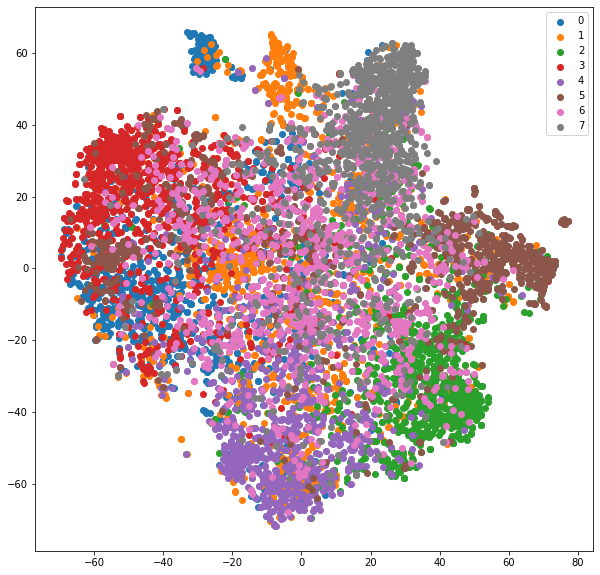

In [ ]:
#Get the hidden layer representation after the first GCN layer
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict([X,A],batch_size=N)

#Get t-SNE Representation
x_tsne = TSNE(n_components=2).fit_transform(activations[3]) 

def plot_tSNE(labels_encoded,x_tsne):
    color_map = np.argmax(labels_encoded, axis=1)
    plt.figure(figsize=(10,10))
    for cl in range(num_classes):
        indices = np.where(color_map==cl)
        indices = indices[0]
        plt.scatter(x_tsne[indices,0], x_tsne[indices, 1], label=cl)
    plt.legend()
    plt.show()
    
plot_tSNE(labels_encoded,x_tsne)